# COVID-19 X-RAY IMAGE CLASSIFICATION


In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
import torch
from torch import nn
from torch import optim
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import densenet121,densenet161,densenet201, resnet101, resnet50, resnet34
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.utils.data import DataLoader

In [2]:
root_path = "../dataset"
train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")

#### Parameters

In [3]:
data_split = False # if it's first time that you run, the code change it to True to prepare data for PyTorch
val_size = 0.2
epochs = 50 # 20, 30, 50, 70
learning_rate = 0.003

## 1- Data Preprocessing

In this section, I change the data's folder to use the ImageLoader in PyTorch. 

In [4]:
if data_split:
    for i in range(2):
        img_list = train_labels.loc[train_labels[train_labels['Label'] == i].index.values, 'File'].values.tolist()
        class_path = os.path.join(train_path, f'{i}')

        print(class_path)
        if not os.path.exists(class_path):
            os.makedirs(class_path)
        for img in img_list:
            shutil.move(train_path+f'/{img}', class_path)

## 2- Data Visualization

In [5]:
train_labels = pd.read_csv(os.path.join(root_path, "train_labels.csv"))

In [6]:
train_labels.head()

,File,Label
0,1329638562-58609.jpg,0
1,956062378-32202.jpg,0
2,118943055-21826.jpg,1
3,211517-1778.jpg,0
4,1001547600-2101.jpg,0


<AxesSubplot:>

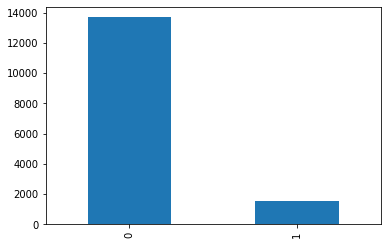

In [7]:
train_labels.Label.value_counts().plot.bar()

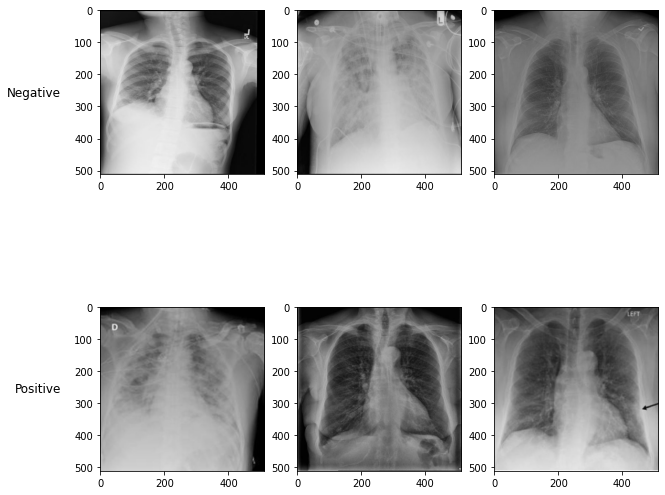

In [8]:
idx = np.random.choice(train_labels[train_labels['Label'] ==0].index.values, 3)
sample_negative_df = train_labels.loc[idx, 'File'].values.tolist()

idx = np.random.choice(train_labels[train_labels['Label'] ==1].index.values, 3)
sample_positive_df = train_labels.loc[idx, 'File'].values.tolist()

fig, axis = plt.subplots(2, 3, figsize=(10, 10))
for i, ax in enumerate(axis.flat):
    if i < 3:
        ax.imshow(Image.open(os.path.join(train_path, '0', sample_negative_df[i])))
    else:
        ax.imshow(Image.open(os.path.join(train_path, '1',sample_positive_df[i-3])))

for ax, row in zip(axis[:,0], ['Negative', 'Positive']):
    ax.annotate(row,xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5,0),                    
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

## 3- Image Preprocessing 
In this part, we define our transformer, and split our train data to train/validation set.

In [9]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    ),
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    ),
])

In [10]:
# Split train data to train and validation!

train_data = ImageFolder(train_path, train_transform)
val_data = ImageFolder(train_path, val_transform)


num_train = len(train_data)
indices = list(range(num_train))
split = int(np.floor(val_size * num_train))

np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=64, num_workers=16)
val_loader = DataLoader(val_data, sampler=val_sampler, batch_size=64, num_workers=16)

## 4- Transfer Learning for Image Classfication

In this section we do the following steps:
1. Load resnet34 pretrained model and freeze the model parameters.
2. Replace fully connected network of model to a custom network.
3. Train FC network with train data.
4. Unfreeze the third and fourth layer of resnet and train the model again with train data.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
# I tried resnet34, 50, 101, but resnet had a better results
model = resnet34(pretrained=True)

# At first round we freeze the all model parameters
for param in model.parameters():
    param.requires_grad = False

In [19]:
model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
#     nn.Dropout(0.5),
    
    nn.Linear(256, 128),
    nn.ReLU(),
    #     nn.Dropout(0.5),

    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1)
)


In [20]:
def train_model(model):
    
    train_losses, valid_losses = [], []

    for epoch in range(epochs):

        model.train()
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0
        
        # Train Model
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(imgs)

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * imgs.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item()



        # Data Validation
        model.eval()
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                output = model.forward(imgs)

                batch_loss = criterion(output, labels)

                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * imgs.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(labels.data.view_as(pred))
                accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                valid_acc += accuracy.item() 

        train_losses.append(train_loss/len(train_loader))
        valid_losses.append(valid_loss/len(val_loader))                    
        print(f"Epoch {epoch+1}/{epochs}.. at time {datetime.now()}: \n"
            f"Train loss: {train_loss/len(train_loader):.3f} \n"
            f"Train accuracy: {train_acc / len(train_loader):.3f} \n "
            f"Validation loss: {valid_loss/len(val_loader):.3f}\n"
            f"Validation accuracy: {valid_acc/len(val_loader):.3f}\n\n")
    return model, train_losses, valid_losses


In [21]:

# weights = [1, 9]
# class_weights = torch.FloatTensor(weights).cuda()
# criterion = nn.CrossEntropyLoss(weight=class_weights).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Train fully connected network
model, _, _ = train_model(model)

Epoch 1/50.. at time 2021-02-14 20:05:31.411774: 
Train loss: 9.426 
Train accuracy: 0.947 
 Validation loss: 7.281
Validation accuracy: 0.963


Epoch 2/50.. at time 2021-02-14 20:05:47.423610: 
Train loss: 6.328 
Train accuracy: 0.964 
 Validation loss: 5.443
Validation accuracy: 0.970


Epoch 3/50.. at time 2021-02-14 20:06:03.603357: 
Train loss: 5.236 
Train accuracy: 0.969 
 Validation loss: 6.024
Validation accuracy: 0.968


Epoch 4/50.. at time 2021-02-14 20:06:19.622071: 
Train loss: 4.302 
Train accuracy: 0.976 
 Validation loss: 6.044
Validation accuracy: 0.972


Epoch 5/50.. at time 2021-02-14 20:06:35.781519: 
Train loss: 3.952 
Train accuracy: 0.977 
 Validation loss: 0.879
Validation accuracy: 0.972


Epoch 6/50.. at time 2021-02-14 20:06:51.956924: 
Train loss: 3.330 
Train accuracy: 0.981 
 Validation loss: 4.276
Validation accuracy: 0.971


Epoch 7/50.. at time 2021-02-14 20:07:08.018522: 
Train loss: 2.821 
Train accuracy: 0.984 
 Validation loss: 8.233
Validation acc

In [23]:
# Train third and fourth layer of the model
for name, child in model.named_children():
    if name in ['layer3', 'layer4']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model, train_losses, val_losses = train_model(model)

Epoch 1/50.. at time 2021-02-14 20:19:04.660502: 
Train loss: 12.103 
Train accuracy: 0.951 
 Validation loss: 16.737
Validation accuracy: 0.952


Epoch 2/50.. at time 2021-02-14 20:19:28.034401: 
Train loss: 6.355 
Train accuracy: 0.966 
 Validation loss: 14.063
Validation accuracy: 0.964


Epoch 3/50.. at time 2021-02-14 20:19:51.251344: 
Train loss: 4.239 
Train accuracy: 0.974 
 Validation loss: 1.406
Validation accuracy: 0.984


Epoch 4/50.. at time 2021-02-14 20:20:14.403403: 
Train loss: 4.082 
Train accuracy: 0.978 
 Validation loss: 0.739
Validation accuracy: 0.941


Epoch 5/50.. at time 2021-02-14 20:20:37.823413: 
Train loss: 2.918 
Train accuracy: 0.983 
 Validation loss: 2.594
Validation accuracy: 0.964


Epoch 6/50.. at time 2021-02-14 20:21:01.191647: 
Train loss: 2.573 
Train accuracy: 0.987 
 Validation loss: 2.422
Validation accuracy: 0.977


Epoch 7/50.. at time 2021-02-14 20:21:24.482097: 
Train loss: 2.123 
Train accuracy: 0.989 
 Validation loss: 0.581
Validation 

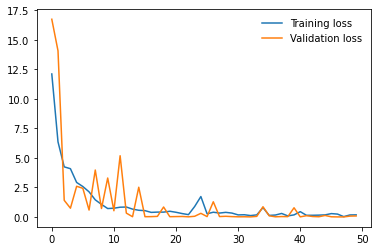

In [24]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
# Save The model
torch.save(model.state_dict(), "covid_model_resnet_v3.pt")

### 3- Prediction

We apply the valid transormer to our test data!

In [25]:
# model=torch.load('covid_model_resnet_v3.pth')
model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# befor running this section please create a seprate folder with any name and put all test data on that.
test_data = ImageFolder(test_path, val_transform)
test_loader = DataLoader(test_data, batch_size=1)

In [27]:
images_name = []
images_label = []

for i, (images, labels) in enumerate(test_loader, 0):
        
    sample_fname, _ = test_loader.dataset.samples[i]
    images, labels = images.to(device), labels.to(device)

    images_name.append(sample_fname.split("/")[-1])
    output = model(images)
    label = output.data.cpu().numpy().argmax()

    images_label.append(label)


In [28]:
df = pd.DataFrame({"File":images_name, "Label":images_label})

In [30]:
# df.to_csv("resnet34_dropout_epoch50_v3.csv",index=False)

#### FINISH!